## Data preparation and sanitization

In [295]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("./UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")

df = df.dropna()


NORMALISE_DATA = True


x = df.values[:, 3:-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)

## Linear regression (continuous dataset)

In [194]:
#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys

def simple_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: mse)
    """
    if loss is None:
        loss = "mse"
    model = Sequential()
    model.add(Dense(3, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='Adam', metrics=metrics)
    return model

**Accuracy / Loss - For model comparison**

In [195]:
MAX_GAIN = 200

def loss(min_offer, predicted):
    """
    Compute loss for the ultimatum game,
    as the difference between the possible gain and the actual one
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    rejected = min_offer > predicted
    res = predicted - min_offer
    if rejected.sum() != 0:
        res[rejected] = MAX_GAIN - min_offer[rejected]
    bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
    if bad_predictions.sum() != 0:
        res[bad_predictions] = MAX_GAIN - min_offer[bad_predictions]
    return res

def loss_sum(min_offer, predicted):
    return loss(min_offer, predicted).sum()

def avg_loss(min_offer, predicted):
    """
    Compute avg loss for the ultimatum game
    """
    return np.mean(loss(min_offer, predicted))

def mse(min_offer, predicted):
    """
    Compute mse using the loss as error
    """
    return np.mean(np.square(loss(min_offer, predicted)))

def rejection_ratio(min_offer, predicted):
    """
    Compute ratio of rejected proposals without consideration of values
    """
    accepted = (min_offer <= predicted)
    return 1 - np.mean(accepted)

def avg_win_loss(min_offer, predicted):
    """
    Compute avg_loss of accepted proposals
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    accepted = (min_offer <= predicted)
    if accepted.sum() == 0:
        return 0
    return avg_loss(min_offer[accepted], predicted[accepted])


def gain(min_offer, predicted):
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()    
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def avg_loss_ratio(min_offer, predicted):
    """
    Compute the avg gain ratio in relation to the maximal gain
    """
    return 1 - np.mean(gain(min_offer, predicted) / gain(min_offer, min_offer))


#### TODO: put a label

In [196]:
benchmark_functions = [avg_loss, mse, rejection_ratio, avg_win_loss, avg_loss_ratio, loss_sum]

from sklearn.model_selection import KFold
import numpy as np

def process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs=None, predict_kwargs=None):
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs
    predict_kwargs = {} if predict_kwargs is None else predict_kwargs
    model.fit(xTrain, yTrain, **fit_kwargs)
    yPredict = model.predict(xTest, **predict_kwargs)
    results = {func.__name__: func(yTest, yPredict) for func in benchmark_functions}
    return results
    
def process_benchmark_cv(model, X, y, cv=5, metrics=None, fit_kwargs=None, predict_kwargs=None):
    kf = KFold(n_splits=cv)
    results = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        xTest, yTest = X[test_index], y[test_index]
        benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
        results.append(benchmark_result)
    return pd.DataFrame(results)

In [197]:
# #sci-kit like training
# sm = simple_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

In [198]:
#gain_ratio(yTest, smPredict)

**Observation of the the "accuracy" *gain_ratio* **

In [199]:
#gr = process_mlp(xTrain, yTrain, xTest, yTest, loss_gain_sigmoid, [gain_ratio_tf, "mse"], validation_split=1/4, verbose=2, epochs=100)

**Cross validation checking mse, mse+offset(poor), and loss_gain**

In [200]:
#process_mlp_cv(x, y, loss_mse)

In [201]:
#process_mlp_cv(x, y, loss_mse_offset)

In [202]:
#process_mlp_cv(x, y, loss_gain_cont)

In [203]:
#process_mlp_cv(x, y, loss_gain_sigmoid)

**Featureless model (fixed value)**

In [278]:
class FeatureLessModel(object):
    def __init__(self, max_value, loss=None):
        self.value = None
        self.max_value = max_value
        self.loss = loss or avg_loss_ratio
        self._trained = False
    
    def fit(self, xTrain, yTrain, **kwargs):
        min_loss = float('inf')
        best_value = 0
        for value in np.arange(self.max_value):
            fixedPredict = np.ones_like(yTrain) * value
            loss = self.loss(yTrain, fixedPredict)
            if loss < min_loss:
                min_loss = loss
                best_value = value
        self._trained = True
        self.value = best_value
    
    def predict(self, xTrain, **kwargs):
        if not self._trained:
            raise ValueError("The model first need to be trained!!!")
        res = np.ones((xTrain.shape[0], 1) ) * self.value
        return res

    


In [293]:
model = FeatureLessModel(MAX_GAIN, loss=avg_loss)
res = process_benchmark_cv(model, x, y)
res

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
0,27.916667,0.212045,25.294118,1005.0,1664.583333,0.055556
1,26.250000,0.227199,23.030303,945.0,1396.527778,0.083333
2,30.000000,0.262607,25.937500,1080.0,1861.111111,0.111111
3,23.750000,0.192169,21.323529,855.0,1296.527778,0.055556
4,26.571429,0.196613,24.558824,930.0,1332.857143,0.028571


**Convervative model**

In [206]:
class ConservativeModel(object):
    def __init__(self, max_value):
        self.value = None
        self.max_value = max_value
        self._trained = False

    def fit(self, xTrain, yTrain, **kwargs):
        self.value = self.max_value - 1
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if not self._trained:
            raise ValueError("The model should first be trained")
        return np.ones((xTest.shape[0], 1)) * self.value

In [207]:
model = ConservativeModel(MAX_GAIN)
res = process_benchmark_cv(model, x, y)
res

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
0,121.361111,0.991272,121.361111,4369.0,15643.083333,0.0
1,116.916667,0.990883,116.916667,4209.0,14550.583333,0.0
2,117.888889,0.986044,117.888889,4244.0,15124.333333,0.0
3,117.194444,0.991019,117.194444,4219.0,14533.361111,0.0
4,122.714286,0.991665,122.714286,4295.0,15572.142857,0.0


**Linear regression**

In [208]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression(copy_X=True)
# res = process_benchmark_cv(regressor, x, y)
# res

**Random forest regressor**

In [290]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=10)
model = RandomForestClassifier()
res = process_benchmark_cv(model, x, y.ravel())
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [210]:
class RandomModel(object):
    def __init__(self, max_value):
        self.value = max_value
        self._trained = False

    def fit(self, xTrain, yTrain, **kwargs):
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if not self._trained:
            raise ValueError("The model should first be trained")
        return np.random.random((xTest.shape[0], 1)) * self.value

In [211]:
model = RandomModel(MAX_GAIN)
res = process_benchmark_cv(model, x, y)
res

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
0,82.943469,0.696981,58.141184,2985.964866,8832.529562,0.416667
1,86.301764,0.732303,73.124500,3106.863507,9229.827661,0.361111
2,77.478808,0.684484,67.169483,2789.237078,7856.372625,0.305556
3,64.603314,0.576651,44.161709,2325.719296,6128.532745,0.361111
4,76.695946,0.631246,57.146005,2684.358119,7844.318755,0.342857


In [300]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN, SpectralClustering, Birch, MiniBatchKMeans, AffinityPropagation


class ClusterModel(object):
    def __init__(self, **kwargs):
        if "base_model" in kwargs:
            base_model_ = kwargs.pop("base_model")
            if isinstance(base_model_, str):
                models = {
                    "kmeans": KMeans,
                    "meanshift": MeanShift,
                    "birch": Birch,
                    "spectral": SpectralClustering,
                    "minibatch": MiniBatchKMeans,
                    "affinity": AffinityPropagation,
                }
                self.base_model = models.get(base_model_, MeanShift)(**kwargs)
            else:
                self.base_model = base_model_
        else:
            self.base_model = MeanShift(**kwargs)
        super().__init__()
        self.clustersClasses = None
        self._trained = False
    
    def fit(self, xTrain, yTrain, **kwargs):
        self.base_model.fit(xTrain)
        labels = np.array([item for item in np.unique(self.base_model.labels_) if item >= 0])
        clustersClasses = np.zeros_like(labels)
        for cluster in range(len(labels)):
            values = yTrain[self.base_model.labels_==cluster]
            clustersClasses[cluster] = values.mean() + values.std()
        self.clustersClasses = clustersClasses
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if self._trained is None:
            raise ValueError("Model not trained yet")
        predClusters = self.base_model.predict(xTest)
        return self.clustersClasses[predClusters]

class ClusterExtModel(object):
    def __init__(self, **kwargs):
        if "base_model" in kwargs:
            base_model_ = kwargs.pop("base_model")
            if isinstance(base_model_, str):
                models = {
                    "kmeans": KMeans,
                    "meanshift": MeanShift,
                    "dbscan": DBSCAN,
                    "spectral": SpectralClustering,
                    "minibatch": MiniBatchKMeans,
                }
                self.base_model = models.get(base_model_, MeanShift)(**kwargs)
            else:
                self.base_model = base_model_
        else:
            self.base_model = MeanShift(**kwargs)
        self._trained = False
        self.sub_models = None
        self.max_value = MAX_GAIN
        
    def fit(self, xTrain, yTrain, **kwargs):        
        self.base_model.fit(xTrain, yTrain, **kwargs)
        labels = np.array([item for item in np.unique(self.base_model.labels_) if item >= 0])
        clustersClasses = np.zeros_like(labels)
        sub_models = []
        for cluster in range(len(labels)):
            sub_model = FeatureLessModel(self.max_value)
            mask = self.base_model.labels_==cluster
            sub_model.fit(xTrain[mask], yTrain[mask])
            sub_models.append(sub_model)
        # We use an array instead of a list for better indexing
        self.clustersClasses = [sub_model.value for sub_model in sub_models]
        self.sub_models = np.array(sub_models)
        print(self.clustersClasses)
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if self._trained is None:
            raise ValueError("Model not trained yet")
        predClusters = self.base_model.predict(xTest)
        sub_models = self.sub_models[predClusters]
        preds = []
        dummy_x = np.array([0])
        for idx in range(xTest.shape[0]):
            preds.append(sub_models[idx].predict(dummy_x))
        res = np.array(preds).ravel()
        return res
        #return self.clustersClasses[predClusters]
            

In [308]:
model = ClusterModel(base_model="affinity", )
#res = process_benchmark_cv(model, x, y)
model.fit(x, y.ravel())
model.clustersClasses

array([110, 121,  99, 104,  89,  90, 100,  98, 109,  93, 110,  99, 144,
        87, 104, 118, 112])

In [214]:
from sklearn.svm import SVR
model = SVR()
res = process_benchmark_cv(model, x, y.ravel())
res

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
0,64.436018,0.596191,30.816481,2319.696665,5606.077763,0.500000
1,61.744591,0.597377,23.400310,2222.805263,5474.712463,0.527778
2,62.713889,0.606452,27.511765,2257.700000,5587.652435,0.527778
3,60.269444,0.574558,23.594444,2169.700000,5324.722361,0.500000
4,54.037164,0.480866,25.740943,1891.300741,4507.754319,0.371429


In [312]:
benchmark_models = {
    #"random": RandomModel(MAX_GAIN),
    "affinity": ClusterModel(base_model="affinity"),
    #"cluster_km": ClusterModel(base_model="kmeans", n_clusters=16),
    #"cluster_meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    #"cluster_birch": ClusterModel(base_model="birch"),
    "affinity_ext": ClusterExtModel(base_model="kmeans", n_clusters=16),
    "cluster_ext_meanshift": ClusterExtModel(base_model="meanshift", cluster_all=True),
    #"cluster_meanshift": ClusterModel(base_model="meanshift"),
    #"cluster_ext": ClusterExtModel(base_model="birch"),
    #"linear_regressor": LinearRegression(copy_X=True),
    #"conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeatureLessModel(MAX_GAIN),
    #"random_forest": RandomForestClassifier(),#max_depth=3, random_state=0, n_estimators=10),
    "random_forest_regr": RandomForestRegressor(),
    #"nn_regression:": simple_model(),
}

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}

[100, 100, 100, 100, 120, 100, 100, 100, 100, 125, 105, 100, 80, 100, 100, 80]
[100, 100, 100, 100, 100, 100, 50, 105, 100, 100, 120, 100, 105, 100, 100, 100]
[75, 100, 100, 100, 100, 100, 100, 80, 120, 100, 100, 100, 100, 100, 105, 105]
[100, 100, 100, 100, 110, 100, 100, 105, 100, 100, 100, 80, 100, 105, 80, 100]
[100, 100, 95, 100, 90, 105, 100, 100, 100, 100, 100, 100, 100, 100, 100, 110]
[100]
[100]
[100]
[100]
[100]


**Performances**

In [313]:
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
affinity,42.093492,0.358552,33.541260,1506.6,2851.099206,0.156349
affinity_ext,28.971429,0.236096,25.815898,1037.0,1687.246032,0.072540
cluster_ext_meanshift,26.897619,0.218127,24.028855,963.0,1510.321429,0.066825
featureless,26.897619,0.218127,24.028855,963.0,1510.321429,0.066825
random_forest_regr,67.971825,0.628300,25.952460,2433.9,6424.044087,0.552857


In [314]:
pd.DataFrame(results_std).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
affinity,4.367382,0.045683,3.140378,154.062650,308.092206,0.036864
affinity_ext,3.488044,0.032673,3.138044,124.378455,343.136827,0.024588
cluster_ext_meanshift,2.296549,0.028436,1.860146,84.454130,243.413449,0.031429
featureless,2.296549,0.028436,1.860146,84.454130,243.413449,0.031429
random_forest_regr,5.719627,0.051398,4.958455,215.055632,818.769309,0.050385


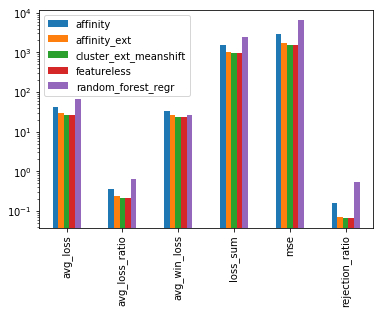

In [315]:
import seaborn as sb
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True)

In [316]:
y[:, -1].mean(), y[:, -1].std()

(79.80446927374301, 29.570307886750392)

In [220]:
df.describe()

,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,92.765363,78.156425,79.525140,45955.307263,27.340782,28.379888,53273.743017,13.273743,3.503352,3.307821,3.254190,79.804469
std,28.240156,28.008989,32.652807,29132.942323,16.082689,19.940948,29945.417255,5.305068,0.556564,0.720366,0.595226,29.653254
min,10.000000,5.000000,0.000000,0.000000,1.000000,0.000000,16000.000000,0.000000,1.900000,1.100000,1.500000,0.000000
25%,85.000000,50.000000,50.000000,26000.000000,12.000000,12.500000,35500.000000,9.000000,3.100000,2.900000,2.900000,50.000000
50%,100.000000,80.000000,80.000000,39000.000000,22.000000,30.000000,47000.000000,14.000000,3.500000,3.400000,3.300000,85.000000
75%,100.000000,100.000000,100.000000,60000.000000,48.500000,45.000000,60500.000000,18.000000,3.900000,3.800000,3.600000,100.000000
max,200.000000,190.000000,190.000000,152000.000000,50.000000,60.000000,269000.000000,20.000000,4.900000,4.800000,4.800000,195.000000


In [221]:
df[df.min_offer<=10]

,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
14,100,50,45,19000,20,60,55000,20,3.0,2.6,2.5,5
42,100,100,50,60000,50,0,33000,18,4.4,2.5,3.0,0
94,10,5,5,31000,50,40,35000,15,2.9,3.5,3.0,10
97,160,50,20,12000,11,0,94000,2,3.6,3.8,3.4,10
115,100,50,50,25000,25,30,44000,20,2.9,1.8,1.6,5
122,20,50,30,77000,36,15,36000,19,3.4,4.0,3.2,10
149,10,5,5,29000,4,15,42000,14,2.5,3.8,3.2,10
